In [1]:
import numpy as np
import wget
import os

In [2]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import numpy as np
cuda = torch.cuda.is_available()
#cuda = False;

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils import data as D

In [4]:
# Tutorail for torch version:
torch.__version__

'1.2.0'

In [5]:
data = ['house','tree', 'bicycle', 'dog', 'horse', 'car', 'clock', 'table','bus', 'laptop', 'mountain', 'pizza', 'sheep', 'shark']

for item in data:
    if not os.path.exists(item + '.npy'):
        url = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/' +item +'.npy'
        wget.download(url)

In [6]:
all_data = []
for type in data:
     all_data.append(np.load(type + '.npy'))

In [ ]:
start = 0
num_examples = 50000
image_df = np.zeros((num_examples ,784))
label_df = []

while start < num_examples :
    random_class = np.random.randint(0,len(data))
    random_index = np.random.randint(0,10000)
    image_df[start] = all_data[random_class][random_index,:]/255
    label_df.append(random_class)
    start += 1


In [ ]:
image_df.shape

In [ ]:
len(label_df)

In [14]:
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
image_train, image_test, label_train, label_test = train_test_split(image_df, label_df, test_size=0.2, random_state=42)

In [ ]:
print(len(image_train))
print(len(image_test))

In [75]:
class ObjectDS(D.Dataset):
    """
    A customized data loader.
    """
    def __init__(self, image_df, label_df):
        self.image_df = image_df
        self.label_df = label_df
        self.len = len(image_df)
    
    # You must override __getitem__ and __len__
    def __getitem__(self, index):
        """ Get a sample from the dataset"""
        
        return (torch.tensor(image_df[index].reshape(1,28,28)).float(), label_df[index])

    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len


In [ ]:
class ObjectDS_Siam(D.Dataset):
    """
    A customized data loader.
    """
    def __init__(self, image_df, label_df, train):
        """ Intialize the dataset
        """
        self.cuda = cuda
        self.image_df = image_df
        self.label_df = label_df
        self.len = len(image_df)
        self.train = train
        #Loop thru each image to get a pair
        self.test_data = []
        for i in range(self.len):
            random_image = np.random.randint(0,self.len)
            if(self.label_df[i] == self.label_df[random_image]):
                self.test_data.append([i,random_image,1])
            else:
                self.test_data.append([i,random_image,0])
    
    # You must override __getitem__ and __len__
    def __getitem__(self, index):
        """ Get a sample from the dataset
        """
        if self.train:
            target = np.random.randint(0, 2)
            if target == 1:
                #Return a pair of image that belong to same class
                same = False;
                while not same:
                    pic1 = np.random.randint(0, self.len)
                    pic2 = np.random.randint(0, self.len)
                    if(self.label_df[pic1]==self.label_df[pic2]):
                        same = True;
                img1 = torch.tensor(self.image_df[pic1]).reshape(1,28,28).float()
                img2 = torch.tensor(self.image_df[pic2]).reshape(1,28,28).float()
            else: 
                #return apair of image that does not belong to same class
                different = False;
                while not different:
                    pic1 = np.random.randint(0, self.len)
                    pic2 = np.random.randint(0, self.len)
                    if(self.label_df[pic1]!=self.label_df[pic2]):
                        different = True;
                img1 = torch.tensor(self.image_df[pic1]).reshape(1,28,28).float()
                img2 = torch.tensor(self.image_df[pic2]).reshape(1,28,28).float()
        else:
            #return fix pair of imags
            pic1  = self.test_data[index][0]
            img1 = torch.tensor(self.image_df[pic1]).reshape(1,28,28).float()
            pic2 = self.test_data[index][1]
            img2 = torch.tensor(self.image_df[pic2]).reshape(1,28,28).float()
            target = self.test_data[index][2]
        return (img1, img2), target
            
                
        #return (torch.tensor(image_df[index].reshape(1,28,28)).float(), label_df[index])

    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len


In [ ]:
train_dataset_base = ObjectDS(image_train, label_train)
test_dataset_base = ObjectDS(image_test, label_test)
train_dataset_siam = ObjectDS_Siam(image_train, label_train,True)
test_dataset_siam = ObjectDS_Siam(image_test, label_test,False)

In [ ]:
# Set up data loaders
n_classes = len(data)
batch_size = 256
kwargs = {'num_workers': 0, 'pin_memory': True} if cuda else {}
train_loader_base = torch.utils.data.DataLoader(train_dataset_base, batch_size=batch_size, shuffle=True, **kwargs)
test_loader_base = torch.utils.data.DataLoader(test_dataset_base, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
#from networks import EmbeddingNet, ClassificationNet
#from metrics import AccumulatedAccuracyMetric

#embedding_net = EmbeddingNet()
#model = ClassificationNet(embedding_net, n_classes=n_classes)
#if cuda:
 #   model.cuda()
#loss_fn = torch.nn.NLLLoss()
#lr = 1e-2
#optimizer = optim.Adam(model.parameters(), lr=lr)
#scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
#n_epochs = 20
#log_interval = 50

In [ ]:
#fit(train_loader_base, test_loader_base, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AccumulatedAccuracyMetric()])

In [ ]:
batch_size = 128
kwargs = {'num_workers': 0, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(train_dataset_siam, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(test_dataset_siam, batch_size=batch_size, shuffle=False, **kwargs)

In [19]:
# Set up the network and training parameters
from networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss

margin = 1.
embedding_net = EmbeddingNet()
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

In [ ]:
fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

In [ ]:
#mnist_classes = ['house','tree', 'bicycle', 'dog', 'horse', 'car', 'clock', 'table']
#colors = ['#d4fe80','#6bfde4','#4b4a48','#edb477','#edeeff',
   #       '#053b06','#a24936','#5f0f40','#efefd0','#ff8306',
  #        '#017f8d','#38293e','#100d11','#1d2124']

colors = ['#F2F3F4', '#222222', '#F3C300', '#875692', '#F38400', 
          '#A1CAF1', '#BE0032', '#C2B280', '#848482', '#008856', 
          '#E68FAC', '#0067A5', '#F99379', '#604E97', '#F6A600', 
          '#B3446C', '#DCD300', '#882D17', '#8DB600', '#654522', 
          '#E25822', '#2B3D26']




def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(20,20))
    for i in range(len(data)):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.3, color=colors[i])
        plt.text(np.mean(embeddings[inds,0]), np.mean(embeddings[inds,1]), data[i])
        
                           
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(data)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            #print(model.get_embedding(images).data.cpu().numpy()[0])
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

In [ ]:
train_embeddings_cl, train_labels_cl = extract_embeddings(train_loader_base, model)
plot_embeddings(train_embeddings_cl, train_labels_cl)


## Thresholding work

In [ ]:
coordinates = [];
objects_embeddings = {}

def embeddings_get_info(embeddings, targets, xlim=None, ylim=None):
    for i in range(len(data)):
        inds = np.where(targets==i)[0]
        coordinates.append(np.mean(embeddings[inds,0])) #Append x coordinate
        coordinates.append(np.mean(embeddings[inds,1])) #Append y coordinate
        objects_embeddings[data[i]] = np.stack((embeddings[inds,0],embeddings[inds,1]), axis=-1)
        
        

In [ ]:
embeddings_get_info(train_embeddings_cl, train_labels_cl)

In [ ]:
val_embeddings_cl, val_labels_cl = extract_embeddings(test_loader_base, model)
plot_embeddings(val_embeddings_cl, val_labels_cl)

In [ ]:
from scipy.spatial import distance

In [ ]:
pairwise_distance = {}

for first_object_ind in range(len(data)):
    for sec_object_ind in range(first_object_ind,len(data)):
        a = (coordinates[2*first_object_ind],coordinates[2*first_object_ind+1])
        #print(data[first_object_ind])
        b = (coordinates[2*sec_object_ind],coordinates[2*sec_object_ind+1])
        #print(data[sec_object_ind])
        #print(distance.euclidean(a, b))
        pairwise_distance[data[first_object_ind] +"-"+ data[sec_object_ind]] = distance.euclidean(a, b)
        
        

In [ ]:
import operator

In [ ]:
sorted_x = sorted(pairwise_distance.items(), key=operator.itemgetter(1))


In [ ]:
from scipy import stats

In [ ]:
intraclass_stats = []
for i in sorted_x[14:]:
    intraclass_stats.append(i[1])
print(np.percentile(intraclass_stats, 1))

In [ ]:
objects_embeddings['house']

In [ ]:
>>> from scipy.cluster.hierarchy import average, fcluster
>>> from scipy.spatial.distance import pdist, squareform

In [ ]:
 y = pdist(objects_embeddings['house'])

In [ ]:
intra_class = []
for i in data:
    y = pdist(objects_embeddings[i])
    print(i, np.mean(y))
    intra_class.append(np.mean(y))

In [ ]:
val_embeddings_cl.shape

In [ ]:
#Getting all pairs that have distance less than threshold
squareform(pdist(val_embeddings_cl)) < 0.22126381396234512

In [ ]:
threshold_similar =  0.03

In [ ]:
x_object = np.where(squareform(pdist(val_embeddings_cl)) <= threshold_similar)[0]
y_object = np.where(squareform(pdist(val_embeddings_cl)) <= threshold_similar)[1]

In [ ]:
pairs_of_object = np.stack((x_object,y_object), axis=-1)

In [ ]:
count_true_positive = 0
for pair in pairs_of_object:
    #if val_labels_cl[pair[0]] == val_labels_cl[pair[1]] or (val_labels_cl[pair[0]] == 3 and val_labels_cl[pair[1]] == 4) or (val_labels_cl[pair[0]] == 4 and val_labels_cl[pair[1]] == 3):
    if val_labels_cl[pair[0]] == val_labels_cl[pair[1]]:
        count_true_positive += 1 #Increase if they are truly similar

In [ ]:
print("Precision", count_true_positive/len(pairs_of_object))

In [ ]:
x_object = np.where(squareform(pdist(val_embeddings_cl)) > threshold_similar)[0]
y_object = np.where(squareform(pdist(val_embeddings_cl)) > threshold_similar)[1]
pairs_of_object_different = np.stack((x_object,y_object), axis=-1)


In [ ]:
len(pairs_of_object_different)

In [ ]:
from IPython import display

In [111]:
from tqdm import tqdm

In [ ]:
count_false_negative = 0
i_count = []
i =0
for pair in tqdm(pairs_of_object_different):
    #if val_labels_cl[pair[0]] == val_labels_cl[pair[1]] or (val_labels_cl[pair[0]] == 3 and val_labels_cl[pair[1]] == 4) or (val_labels_cl[pair[0]] == 4 and val_labels_cl[pair[1]] == 3):
    if val_labels_cl[pair[0]] == val_labels_cl[pair[1]]:
        count_false_negative += 1


In [ ]:
count_false_negative

In [ ]:
print("Recall", count_true_positive/(count_true_positive+count_false_negative))

## Similarity measure Siam

In [7]:
import cv2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [162]:
start = 0
num_examples = 100000
image_df = np.zeros((num_examples ,784))
label_df = []

while start < num_examples :
    two_classes = np.random.choice(range(10), 2)
    temp1 = all_data[two_classes[0]]
    temp2 = all_data[two_classes[1]]
            
    img_generated = np.zeros((28,28)) #A big canvas
    
    random_index = np.random.randint(0,10000)
    pic_1 = temp1[random_index,:]/255

    random_index = np.random.randint(0,10000)
    pic_2 = temp2[random_index,:]/255
    pic_1 = cv2.resize(pic_1.reshape(28,28),(14,14))
    pic_2 = cv2.resize(pic_2.reshape(28,28),(14,14))
    random_chance = np.random.randint(0,2)
    if(random_chance == 0):
        img_generated[7:21,0:14] = pic_1.reshape(14,14)
        img_generated[7:21,14:28] = pic_2.reshape(14,14)
    else:
        img_generated[7:21,0:14] = pic_2.reshape(14,14)
        img_generated[7:21,14:28] = pic_1.reshape(14,14)
    image_df[start] = img_generated.reshape(1,784)
    label_df.append(str(two_classes[0])+str(two_classes[1]))
    start += 1
    

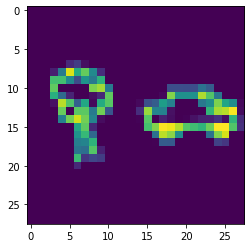

In [163]:
imshow(image_df[4].reshape(28,28))

In [164]:
import textdistance

In [165]:
class ObjectDS_Siam_Similarity(D.Dataset):
    """
    A customized data loader.
    """
    def __init__(self, image_df, label_df, train):
        """ Intialize the dataset
        """
        self.count_per_test = 100
        self.image_df = image_df
        self.label_df = label_df
        self.train = train
        
        #Prepare test_data
        if not train:
            self.test_data = []
            length_image_df = len(image_df)
            for i in range(length_image_df):
                for k in range(self.count_per_test):
                    random_image = np.random.randint(0,length_image_df)
                    distance = textdistance.overlap(self.label_df[i] , self.label_df[random_image])
                    self.test_data.append([i,random_image,distance])
            self.len = len(self.image_df)  * self.count_per_test
        else:
            self.len = len(self.image_df)
        
            
    
    # You must override __getitem__ and __len__
    def __getitem__(self, index):
        """ Get a sample from the dataset
        """
        if self.train:
            chance = np.random.randint(0, 3)
            if chance == 0:
                #Return a pair of image that is not so different
                ok = False;
                while not ok:
                    pic1 = np.random.randint(0, self.len)
                    pic2 = np.random.randint(0, self.len)
                    distance = textdistance.overlap(self.label_df[pic1] , self.label_df[pic2])
                    if(distance == 0):
                        ok = True;
                img1 = torch.tensor(self.image_df[pic1]).reshape(1,28,28).float()
                img2 = torch.tensor(self.image_df[pic2]).reshape(1,28,28).float()
            elif chance == 1: 
                #return apair of image that is very different
                ok = False;
                while not ok:
                    pic1 = np.random.randint(0, self.len)
                    pic2 = np.random.randint(0, self.len)
                    distance = textdistance.overlap(self.label_df[pic1] , self.label_df[pic2]) 
                    if(distance == 0.5):
                        ok = True;
                img1 = torch.tensor(self.image_df[pic1]).reshape(1,28,28).float()
                img2 = torch.tensor(self.image_df[pic2]).reshape(1,28,28).float()
            else:
                ok = False;
                while not ok:
                    pic1 = np.random.randint(0, self.len)
                    pic2 = np.random.randint(0, self.len)
                    distance = textdistance.overlap(self.label_df[pic1] , self.label_df[pic2]) 
                    if(distance == 1):
                        ok = True;
                img1 = torch.tensor(self.image_df[pic1]).reshape(1,28,28).float()
                img2 = torch.tensor(self.image_df[pic2]).reshape(1,28,28).float()
            target = distance
        else:
            #return fix pair of imags
            pic1  = self.test_data[index][0]
            img1 = torch.tensor(self.image_df[pic1]).reshape(1,28,28).float()
            pic2 = self.test_data[index][1]
            img2 = torch.tensor(self.image_df[pic2]).reshape(1,28,28).float()
            target = self.test_data[index][2]
        return (img1, img2), target
            
                
        #return (torch.tensor(image_df[index].reshape(1,28,28)).float(), label_df[index])

    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len


In [171]:
image_train, image_test, label_train, label_test = train_test_split(image_df, label_df, test_size=0.05, random_state=42)

In [172]:
train_dataset_siam_similarity = ObjectDS_Siam_Similarity(image_train, label_train,True)
test_dataset_siam_similarity = ObjectDS_Siam_Similarity(image_test, label_test,False)

In [173]:
batch_size = 128
kwargs = {'num_workers': 0, 'pin_memory': True} if cuda else {}
siamese_similarity_train_loader = torch.utils.data.DataLoader(train_dataset_siam_similarity, batch_size=batch_size, shuffle=True, **kwargs)
siamese_similarity_test_loader = torch.utils.data.DataLoader(test_dataset_siam_similarity, batch_size=batch_size, shuffle=False, **kwargs)

In [174]:
margin = 1.
embedding_net = EmbeddingNet()
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 40
log_interval = 100

In [175]:
fit(siamese_similarity_train_loader, siamese_similarity_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/95000 (0%)]	Loss: 0.229053
Train: [12800/95000 (13%)]	Loss: 0.124194
Train: [25600/95000 (27%)]	Loss: 0.108027
Train: [38400/95000 (40%)]	Loss: 0.106291
Train: [51200/95000 (54%)]	Loss: 0.103791
Train: [64000/95000 (67%)]	Loss: 0.103701
Train: [76800/95000 (81%)]	Loss: 0.101408
Train: [89600/95000 (94%)]	Loss: 0.099032
Epoch: 1/40. Train set: Average loss: 0.1063
Epoch: 1/40. Validation set: Average loss: 0.1122
Train: [0/95000 (0%)]	Loss: 0.103257
Train: [12800/95000 (13%)]	Loss: 0.097762
Train: [25600/95000 (27%)]	Loss: 0.096679
Train: [38400/95000 (40%)]	Loss: 0.095965
Train: [51200/95000 (54%)]	Loss: 0.094474
Train: [64000/95000 (67%)]	Loss: 0.095833
Train: [76800/95000 (81%)]	Loss: 0.094099
Train: [89600/95000 (94%)]	Loss: 0.093764
Epoch: 2/40. Train set: Average loss: 0.0955
Epoch: 2/40. Validation set: Average loss: 0.1055
Train: [0/95000 (0%)]	Loss: 0.092805
Train: [12800/95000 (13%)]	Loss: 0.094495
Train: [25600/95000 (27%)]	Loss: 0.093645
Train: [38400/95000 (40%)]	

KeyboardInterrupt: 

In [176]:
train_dataset_base = ObjectDS(image_train, label_train)
test_dataset_base = ObjectDS(image_test, label_test)

In [177]:
# Set up data loaders
n_classes = len(data)
batch_size = 256
kwargs = {'num_workers': 0, 'pin_memory': True} if cuda else {}
train_loader_base = torch.utils.data.DataLoader(train_dataset_base, batch_size=batch_size, shuffle=True, **kwargs)
test_loader_base = torch.utils.data.DataLoader(test_dataset_base, batch_size=batch_size, shuffle=False, **kwargs)

In [178]:
def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(20,20))
    for i in range(len(data)):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.3, color=colors[i])
        plt.text(np.mean(embeddings[inds,0]), np.mean(embeddings[inds,1]), data[i])                     
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(data)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            #print(model.get_embedding(images).data.cpu().numpy()[0])
            #labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings

In [179]:
train_embeddings_cl = extract_embeddings(train_loader_base, model)

In [180]:
train_embeddings_cl.shape

(95000, 2)

In [181]:
len(np.unique(label_train))

100

In [182]:
unique_labels = np.unique(label_train)
print(unique_labels)

['00' '01' '02' '03' '04' '05' '06' '07' '08' '09' '10' '11' '12' '13'
 '14' '15' '16' '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27'
 '28' '29' '30' '31' '32' '33' '34' '35' '36' '37' '38' '39' '40' '41'
 '42' '43' '44' '45' '46' '47' '48' '49' '50' '51' '52' '53' '54' '55'
 '56' '57' '58' '59' '60' '61' '62' '63' '64' '65' '66' '67' '68' '69'
 '70' '71' '72' '73' '74' '75' '76' '77' '78' '79' '80' '81' '82' '83'
 '84' '85' '86' '87' '88' '89' '90' '91' '92' '93' '94' '95' '96' '97'
 '98' '99']


In [129]:
colors = ['#F2F3F4', '#222222', '#F3C300', '#875692', '#F38400', 
          '#A1CAF1', '#BE0032', '#C2B280', '#848482', '#008856', 
          '#E68FAC', '#0067A5', '#F99379', '#604E97', '#F6A600', 
          '#B3446C', '#DCD300', '#882D17', '#8DB600', '#654522', 
          '#E25822', '#2B3D26']

100%|██████████████████████████████████████████████████████████████████████████| 95000/95000 [00:11<00:00, 8331.76it/s]


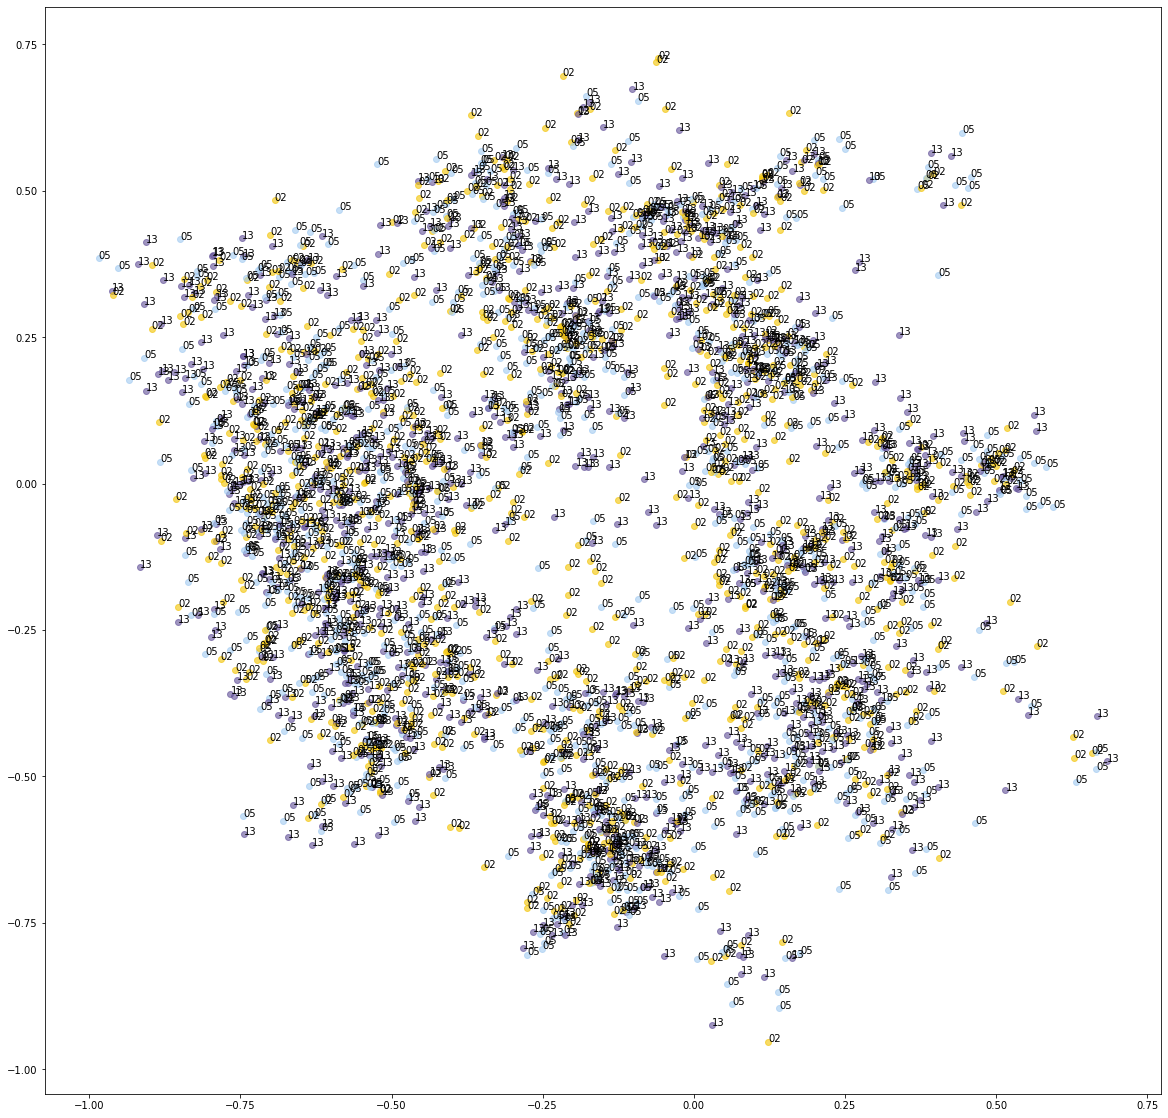

In [192]:
plt.figure(figsize=(20,20))
for i in tqdm(range(95000)):
    if label_train[i] == '05' or label_train[i] == '02' or label_train[i] == '13':
        check = np.where(unique_labels == label_train[i])[0][0] 
        if check < 14:
            plt.scatter(train_embeddings_cl[i,0],train_embeddings_cl[i,1], alpha=0.6, color=colors[check])
            plt.text(np.mean(train_embeddings_cl[i,0]),np.mean(train_embeddings_cl[i,1]),label_train[i] )

## Using non-similarity measure - label to account for that